# Notebook to make Fig. 2

In [1]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd
import lal
import importlib

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("",['#CC79A7', '#D55E00', '#E69F00', '#0072B2'])

from textwrap import wrap
from scipy.signal import hilbert

import seaborn as sns
cp = sns.color_palette('muted')
cp2 = sns.color_palette('pastel')

import sys
sys.path.append('../scripts')
from helper_functions import *
sys.path.append('../utils')
import reconstructwf as rwf

style.use('plotting.mplstyle')

data_dir = '../data/' 

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


### Load in data: strain timeseries

Load in time-domain data from the detectors

In [2]:
data_dict =  np.load(data_dir+'LVC_strain_data.npy', allow_pickle=True).item()
wh_data_dict =  np.load(data_dir+'LVC_strain_data_whitened.npy', allow_pickle=True).item()
time_dict_data =  np.load(data_dir+'LVC_time_data.npy', allow_pickle=True).item()

Load in reconstructions and angles from before/after each cutoff time

In [3]:
# Waveform reconstructions
reconstruction_dict_all = np.load(data_dir+"waveform_reconstructions_all_detectors.npy", allow_pickle=True).item()
reconstruction_dict = {k:reconstruction_dict_all[k]['L1'] for k in reconstruction_dict_all.keys()}

# Angles vs time
angles_vs_time_dict =  np.load(data_dir+'angles_vs_time_dict.npy', allow_pickle=True).item()

Define timeseries

In [4]:
# 0M <-> seconds
t0_0M_dict = {}
t0_0M_geo = 1242442967.405764
dt_10M = 0.0127 # 10 M = 12.7 ms 
dt_1M = dt_10M/10.

ra = 6.07546535866838
dec = -0.8000357325337637

# define t_0M in each detector in seconds
for ifo in ['H1', 'L1', 'V1']: 
    
    t_delay = lal.TimeDelayFromEarthCenter(lal.cached_detector_by_prefix[ifo].location, ra, dec, t0_0M_geo)
    t0_0M_dict[ifo] = t0_0M_geo + t_delay
    
# Transform timeseries into into units of M
L1_LVC_strain = data_dict['L1']
L1_LVC_strain_wh = wh_data_dict['L1']
L1_times_M = (time_dict_data['L1'] - t0_0M_dict['L1'])/dt_1M

reconstruction_times_M = (reconstruction_dict['time samples']- t0_0M_dict['L1'])/dt_1M

Figure out what cutoff time to use to correspond to the peak of the final pre-merger cycle

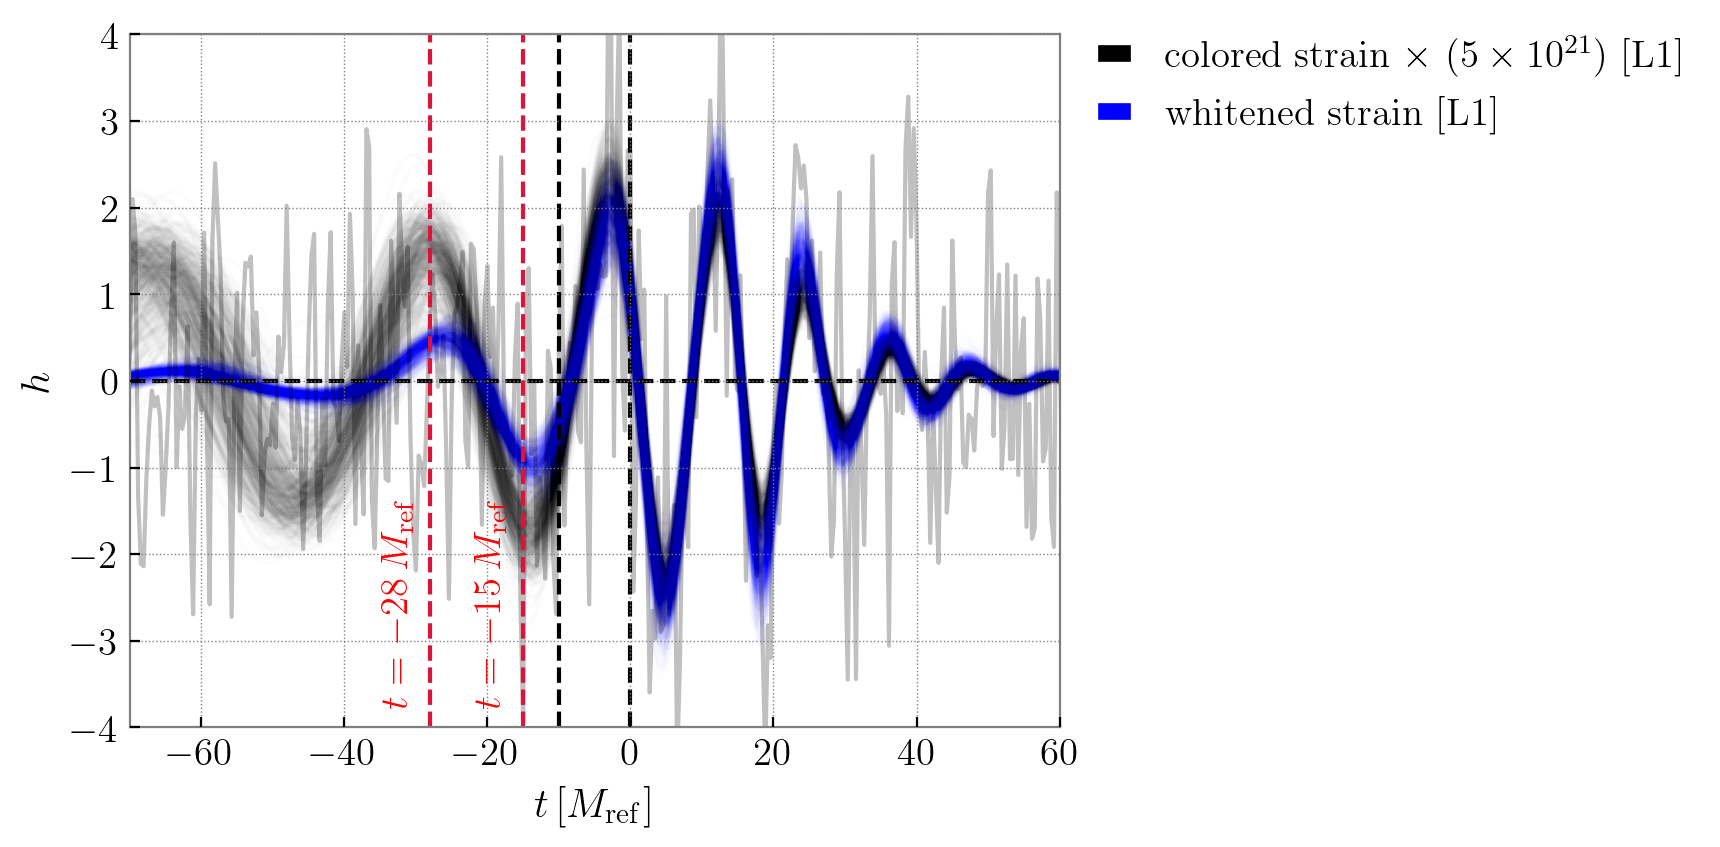

In [5]:
reconstructions_full = np.asarray(reconstruction_dict['full']['h'])
reconstructions_wh = np.asarray(reconstruction_dict['full']['wh'])

idxs = np.random.choice(reconstructions_full.shape[0], 500, replace=False)

alph = 0.01

plt.figure()

plt.plot(L1_times_M, L1_LVC_strain_wh, color='silver')

plt.plot(reconstruction_times_M, reconstructions_full[idxs].T*0.5e22, color='k', alpha=alph)
plt.plot(reconstruction_times_M, reconstructions_wh[idxs].T, color='b', alpha=alph)

plt.ylabel(r'$h$', fontsize=15)
plt.xlabel(r'$t\,[M_\mathrm{ref}]$', fontsize=15)
plt.ylim(-4, 4)
plt.xlim(-70, 60)

handles = [
    Line2D([], [], color='k', label=r'colored strain $\times~(5 \times 10^{21})$ [L1]'),
    Line2D([], [], color='b', label=r'whitened strain [L1]'),

]
plt.legend(handles = handles, loc='upper left', bbox_to_anchor=(1, 1.05))

# Lines
for x in [-15, -28,]: 
    plt.axvline(x, color='crimson', ls='--')
    plt.text(x-7, -3.7, f'$t={{{x}}}\,M_\mathrm{{ref}}$', color='r', fontsize=14, zorder=5, rotation=90)
plt.axhline(0, color='k', ls='--')
plt.axvline(0, color='k', ls='--')
plt.axvline(-10, color='k', ls='--')

plt.show()

Plot phase vs time of waveform reconstructions: 
$$
    \Delta \varphi = \int_{t_0}^{t_\mathrm{ref}} 2 \pi \, f_\mathrm{GW}(t) \, dt
$$

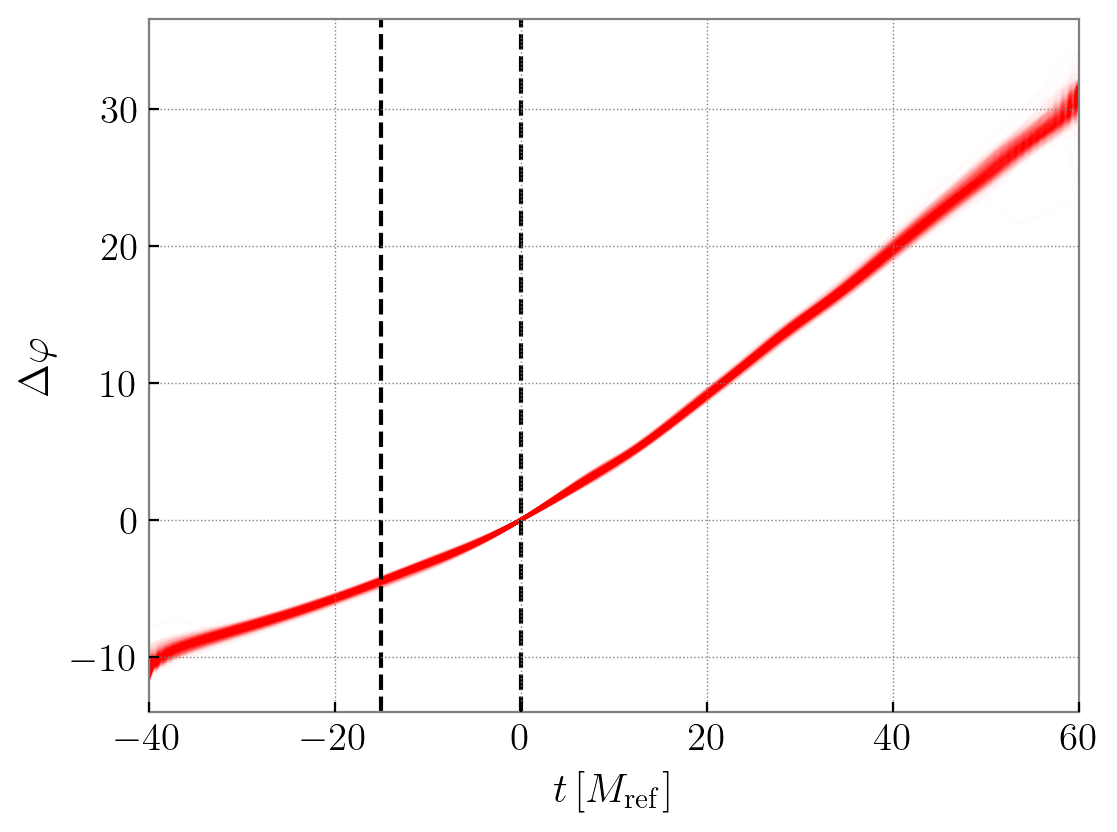

In [6]:
# Only look at relevant times 
bounds = [-40, 60]
mask = (reconstruction_times_M > bounds[0]) & (reconstruction_times_M < bounds[1])

# downsample reconstructions
reconstructions_wh = np.asarray(reconstruction_dict['full']['wh'])[:,mask]
idxs = np.random.choice(reconstructions_wh.shape[0], 500, replace=False)
reconstructions_to_plot = reconstructions_wh[idxs].T

# Hilbert transform
analytical_signals = hilbert(reconstructions_to_plot, axis=0)

# Unpack phase
phase = np.angle(analytical_signals)

# Unwrap
phase_unwrapped = np.unwrap(phase, axis=0)

# Delta phi
delta_phi = phase_unwrapped - phase_unwrapped[np.argmin(np.abs(reconstruction_times_M[mask]))]

plt.figure()

alpha = min(1, 5/len(idxs))
plt.plot(reconstruction_times_M[mask], delta_phi, color='r', alpha=alpha)

plt.axvline(0, color='k', ls='--')
plt.axvline(-15, color='k', ls='--')

plt.ylabel(r'$\Delta \varphi$', fontsize=15)
plt.xlabel(r'$t\,[M_\mathrm{ref}]$', fontsize=15)
plt.xlim(*bounds)


plt.show()

### For reconstruction plot ...

Look at waveform reconstructions for $t>-10M$ and full IMR

In [7]:
# Define some things for plotting
colors_dict = {
    'rd m10M':cmap(0.4),
    'full':'k'
}
n_traces_to_plot = 1000

T_CUT = -15 ## selected from plot above

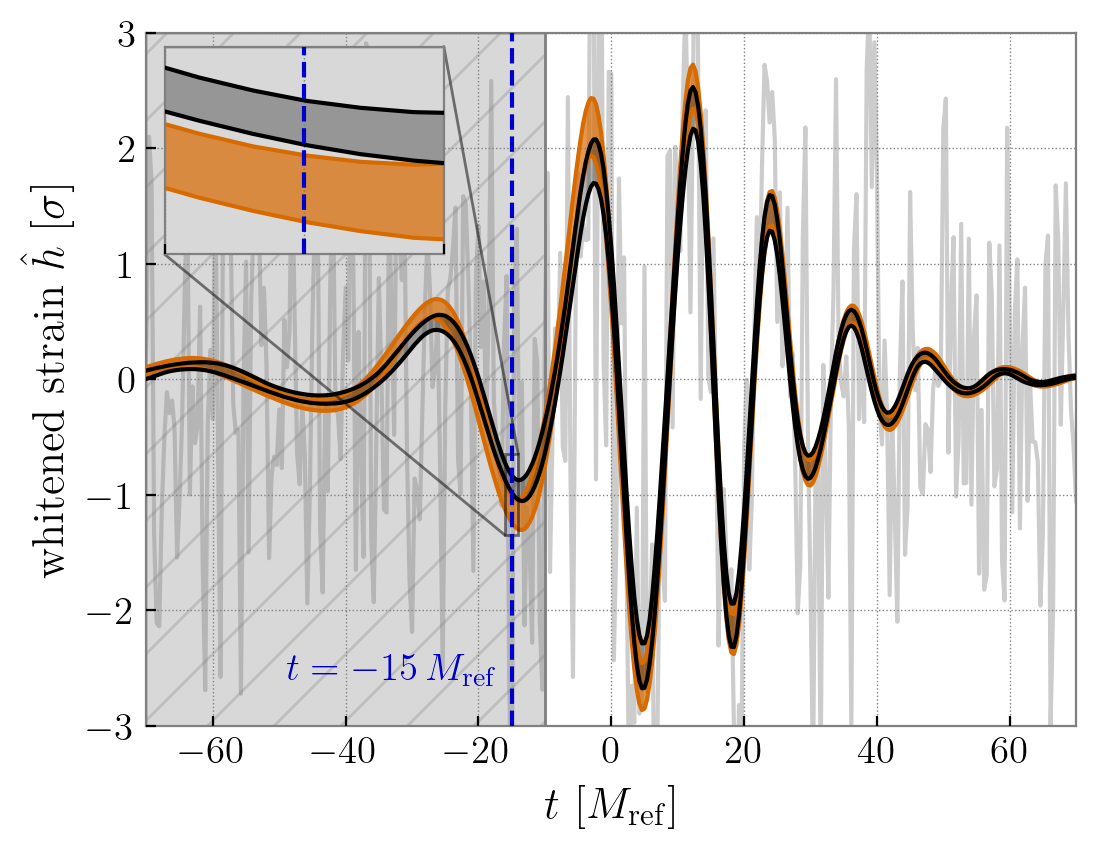

In [8]:
x_lims = [-70, 70]

fig, axes = plt.subplots(1, 1)

# inset axes
l = 0.3
w = 0.3
dx = 0.02
axin = axes.inset_axes([dx, 1-dx-l, l, w])

axes.set_rasterization_zorder(2)
axin.set_rasterization_zorder(2)

# Plot detector data
axes.plot(reconstruction_times_M, L1_LVC_strain_wh, color='k', alpha=0.2, zorder=0)

# Plot reconstructions
for n, ax in enumerate([axes, axin]):
    
    for run in colors_dict.keys():
        
        reconstructions_wh = np.asarray(reconstruction_dict[run]['wh'])

        # Get 50% credible region for whitened reconstructed stain
        quants = np.quantile(reconstructions_wh, [0.25, 0.75], axis=0)
        ax.plot(reconstruction_times_M, np.transpose(quants), 
                  color=colors_dict[run],  alpha=1, zorder=3) 

        alph = 0.7 if run=='rd m10M' else 0.3
        ax.fill_between(reconstruction_times_M, quants[0], y2=quants[1], 
                          color=colors_dict[run], alpha=alph, zorder=2)
            
    
    if n==0:
        shading_kws = dict(hatch='/',  alpha=0.3, color='gray')
    else: 
        shading_kws = dict(alpha=0.3, color='gray')
    ax.axvline(-10, color='gray', zorder=1, lw=1)

    # label the time at which to construct the posteriors
    c = 'mediumblue'
    ax.axvline(T_CUT, color=c, ls='--', zorder=5)
    
    # shade out the 
    ax.axvspan(x_lims[0], -10, **shading_kws, zorder=0)
        
axes.text(T_CUT-34, -2.6, f'$t={{{T_CUT}}}\,M_\mathrm{{ref}}$', color=c, fontsize=14, zorder=5)
axes.set_xlabel(r'$t~[M_\mathrm{ref}]$', fontsize=16)
axes.set_ylabel(r'whitened strain $\hat h~[\sigma]$', fontsize=16)

# Set full axes limits
axes.set_xlim(*x_lims)
axes.set_ylim(-3, 3)

# Format inset
axin.set_xlim(T_CUT - 1, T_CUT + 1)
axin.set_xticklabels([])
axin.set_yticklabels([])
axin.set_ylim(-1.35, -0.65)

axes.indicate_inset_zoom(axin, edgecolor="black")

axin.set_yticks([])

plt.savefig('figure_02a.pdf', bbox_inches='tight')
plt.show()

### For cornerplot ... 

In [9]:
def make_cornerPlot(keys, dict_to_plot, colors_dict, bounds_dict, labels_dict, savename=None, bins=30, 
              labelsize = 15, legend_handles=None, legend_loc=(1,1), text_loc=(1,1), figsize=(6,6)):
    
    # numbers of parameters we are plotting
    ndim = len(keys)
    
    # runs to plot
    runs = dict_to_plot.keys()

    fig = plt.figure(figsize=figsize)

    for i,key in enumerate(keys):

        # Plot the marginal 1D posterior(s) (i.e. top of a corner plot column)
        ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
        
        # Bounds for this parameter
        bounds = bounds_dict[key]
        
        # Add legend if desired
        if i==0 and legend_handles is not None:
            
            # Make legend
            leg = ax.legend(handles=legend_handles, loc='upper left', fontsize=15, 
                      bbox_to_anchor=legend_loc, bbox_transform=ax.transAxes)

            if text_loc is not None:
                ax.text(*text_loc, "Analysis:", ha='center', fontsize=15)


        # Cycle through runs and plot the posterior samples
        for run in runs:

            posterior = dict_to_plot[run][key]

            ax.hist(posterior,bins=np.linspace(*bounds,bins), rasterized=True, density=True, zorder=0, 
                    histtype='step', color=colors_dict[run], lw=1.5)
            
        # Set axis bounds
        ax.set_xlim(*bounds)

        # Turn off tick
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
        ax.set_yticklabels([])
        ax.grid(visible=True, axis='x', which='both')
        ax.grid(visible=False, axis='y', which='both')

        # If this is the last dimension add an x-axis label
        if i==ndim-1:
            ax.set_xlabel(labels_dict[key],fontsize=labelsize)
            if key=='h' or key=='iota' or key=='phase': 
                ax.xaxis.label.set_color('mediumblue')

        # If not the last dimension, loop across other variables and fill in the rest of the column with 2D plots
        else:

            ax.set_xticklabels([])
            for j,k in enumerate(keys[i+1:]):

                # Make a 2D contour plot
                ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))

                # Axes bounds
                x_bounds = bounds_dict[key]
                y_bounds = bounds_dict[k]

                # Cycle through each run and plot the posterior samples
                for run in runs:

                    posterior_x = dict_to_plot[run][key]
                    posterior_y = dict_to_plot[run][k]
                    posterior_df = pd.DataFrame({key:posterior_x, k:posterior_y})

                    # Use seaborn to make a kde plot
                    sns.kdeplot(data=posterior_df, 
                                x=key, y=k,
                                ax=ax, 
                                levels=[0.1, 0.5],
                                fill=False,
                                zorder=2, 
                                color=colors_dict[run], 
                                common_norm=False, 
                                common_grid=False 
                               )

                # Set axis bounds
                ax.set_xlim(*x_bounds)
                ax.set_ylim(*y_bounds)
                ax.xaxis.set_minor_locator(AutoMinorLocator(2))
                ax.yaxis.set_minor_locator(AutoMinorLocator(2))
                ax.grid(True,which='both',dashes=(1,3))

                # If still in the first column, add a y-axis label
                if i==0:
                    ax.set_ylabel(labels_dict[k],fontsize=labelsize)
                    if k=='h' or k=='iota' or k=='phase':
                        ax.yaxis.label.set_color('mediumblue')
                else:
                    ax.set_ylabel('')
                    ax.set_yticklabels([])

                # If on the last row, add an x-axis label
                if j==ndim-i-2:
                    ax.set_xlabel(labels_dict[key],fontsize=labelsize)
                    if key=='h' or key=='iota' or key=='phase':
                        ax.xaxis.label.set_color('mediumblue')  
                else:
                    ax.set_xlabel('')
                    ax.set_xticklabels([])

    plt.subplots_adjust(hspace=0.15, wspace=0.15)
    if savename is not None:
        plt.savefig(savename, bbox_inches='tight')
    plt.show()

Make figure

In [10]:
# Set up data
for_cp_dict = {}
for run in colors_dict.keys():
    
    # chip posterior
    samples =  reconstruction_dict[run]['params']
    m1, m2 = m1m2_from_mtotq(samples['mtotal'], samples['q'])
    chip = chi_precessing(m1, samples['chi1'], samples['tilt1'],
                                m2, samples['chi2'], samples['tilt2'])
    
    # h posterior at t=T_CUT
    idx = np.argmin(np.abs(reconstruction_times_M-T_CUT))
    h_array = np.asarray(reconstruction_dict[run]['wh'])
    h_posterior = np.abs(h_array)[:,idx]
    
    # phase difference between t=0 and t=T_CUT
    phase = np.unwrap(np.angle(hilbert(h_array)))
    phase0 = phase[:,np.argmin(np.abs(reconstruction_times_M))]
    phasem15 = phase[:,idx]
    phase_posterior = np.abs(phase0 - phasem15)
    
    # |iota-pi/2| posterior at t=T_CUT
    iota_vs_time = np.abs(np.array(angles_vs_time_dict[run]['incl']) - np.pi/2)
    time = np.array(angles_vs_time_dict[run]['time_M']) 
    iota_posterior = []
    for iota,t in zip(iota_vs_time, time):
        iota_post = np.interp(T_CUT, t, iota)
        iota_posterior.append(iota_post)
    
    # add to dict
    for_cp_dict[run] = {
        'chip':chip, 
        'h':h_posterior, 
        'iota':iota_posterior, 
        'phase':phase_posterior,

    }

# ... and their bounds
bounds_dict = {
    'chip':(0,1),
    'h':(0.4, 1.7),
    'iota':(0, np.pi/2), 
    'phase':(4, 5)
}

# ... and labels
labels_dict = {
    'chip':r'$\chi_\mathrm{p}$',
    'h':r'$|\hat h_{(-15\,M_\mathrm{ref})}|$',
    'iota':r'$|\iota_{(-15\,M_\mathrm{ref})} - \pi/2|$', 
    'phase':r'$\Delta \varphi_{(-15\,M_\mathrm{ref})}$'
}

legend_handles = [
    Line2D([], [], color=colors_dict['rd m10M'], label=r'post-$t=-10\,M_\mathrm{ref}$'),
    Line2D([], [], color=colors_dict['full'], label='full')
]

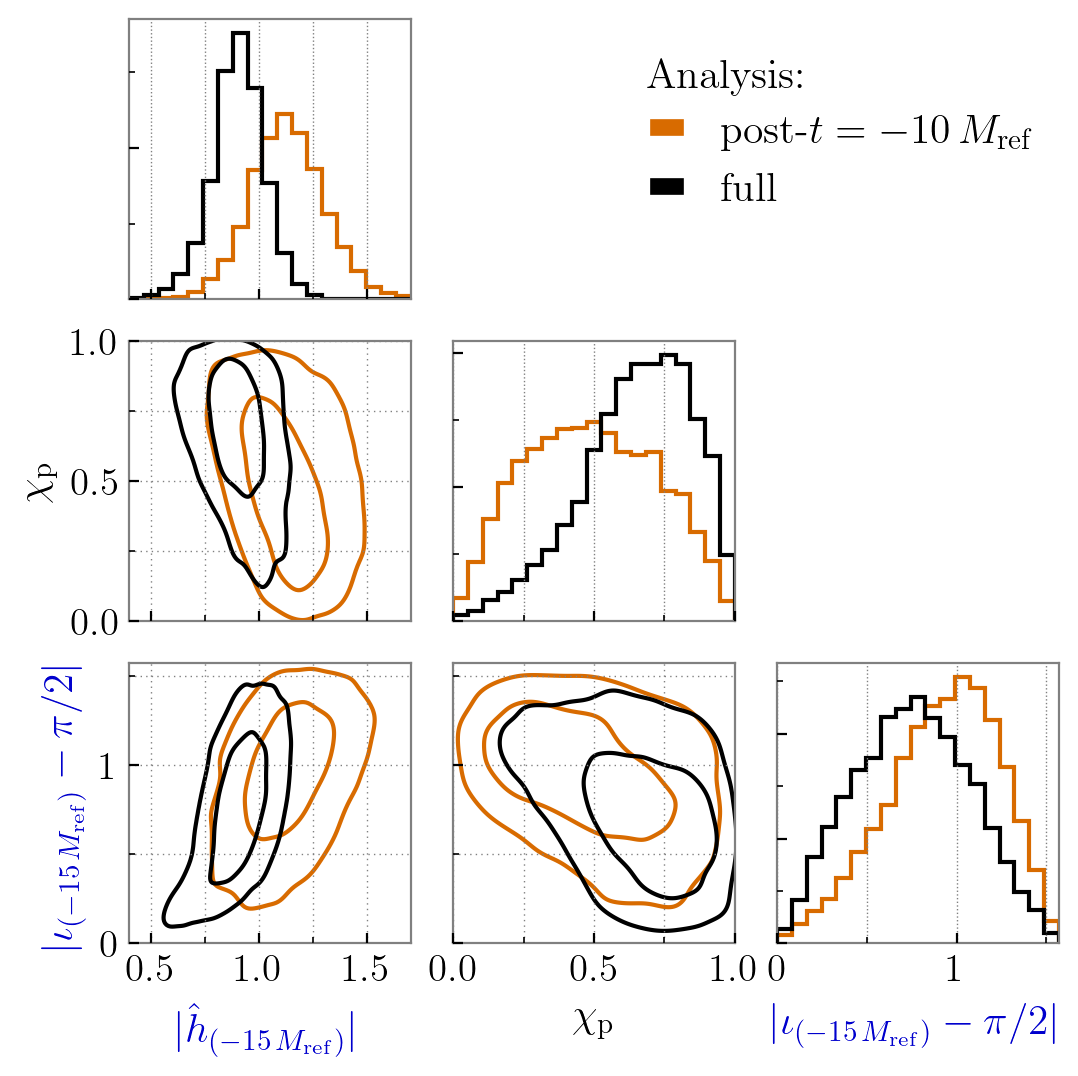

In [11]:
# In version for paper plot amplitude, chip, and inclination angle
make_cornerPlot(
    ['h', 'chip', 'iota'], 
    for_cp_dict,
    colors_dict, 
    bounds_dict, 
    labels_dict, 
    savename='figure_02b.pdf',
    bins=20, 
    legend_handles=legend_handles, 
    legend_loc=(1.7, 0.8), 
    text_loc=(3.16, 2.8)
)

### Other versions of Figure including more/less parameters

Just $|\hat h|$ and $\chi_\mathrm{p}$

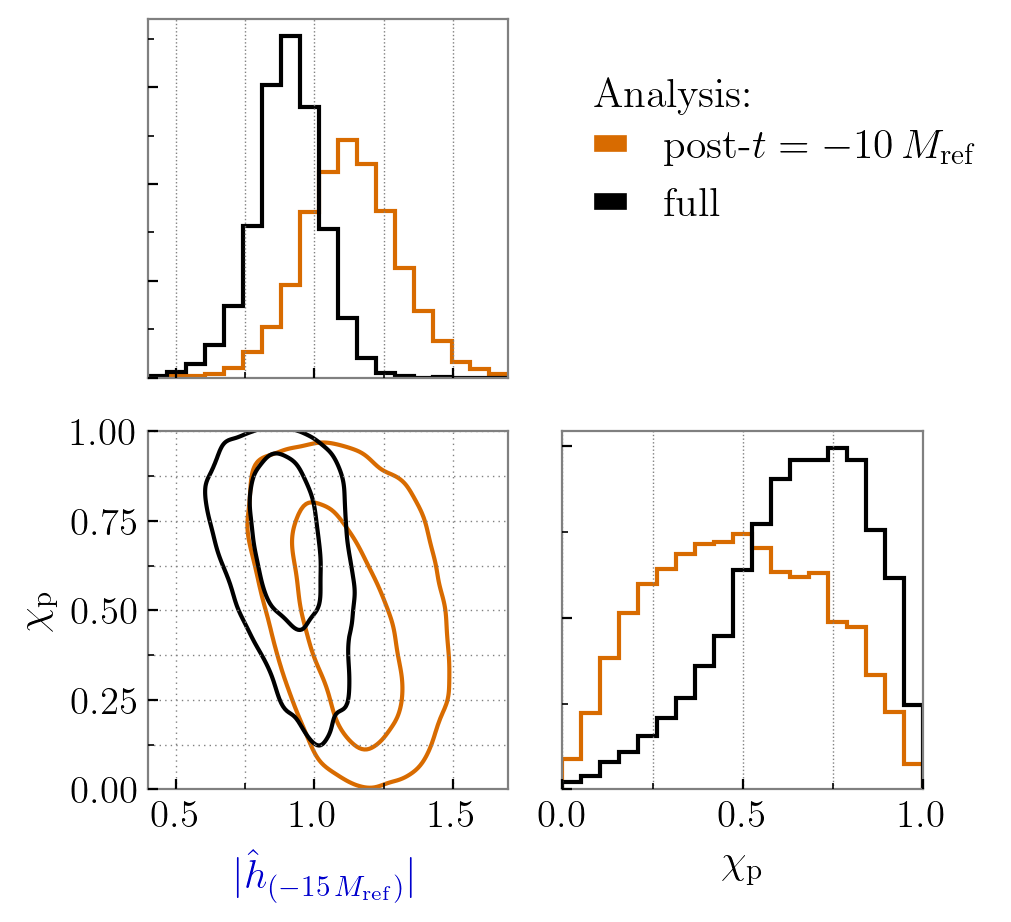

In [12]:
make_cornerPlot(
    ['h', 'chip'], 
    for_cp_dict,
    colors_dict, 
    bounds_dict, 
    labels_dict, 
    bins=20, 
    legend_handles=legend_handles,
    legend_loc=(1.12, 0.8), 
    text_loc=(2.3, 2.8), 
    figsize=(5,5)
)

Including $\Delta\varphi$

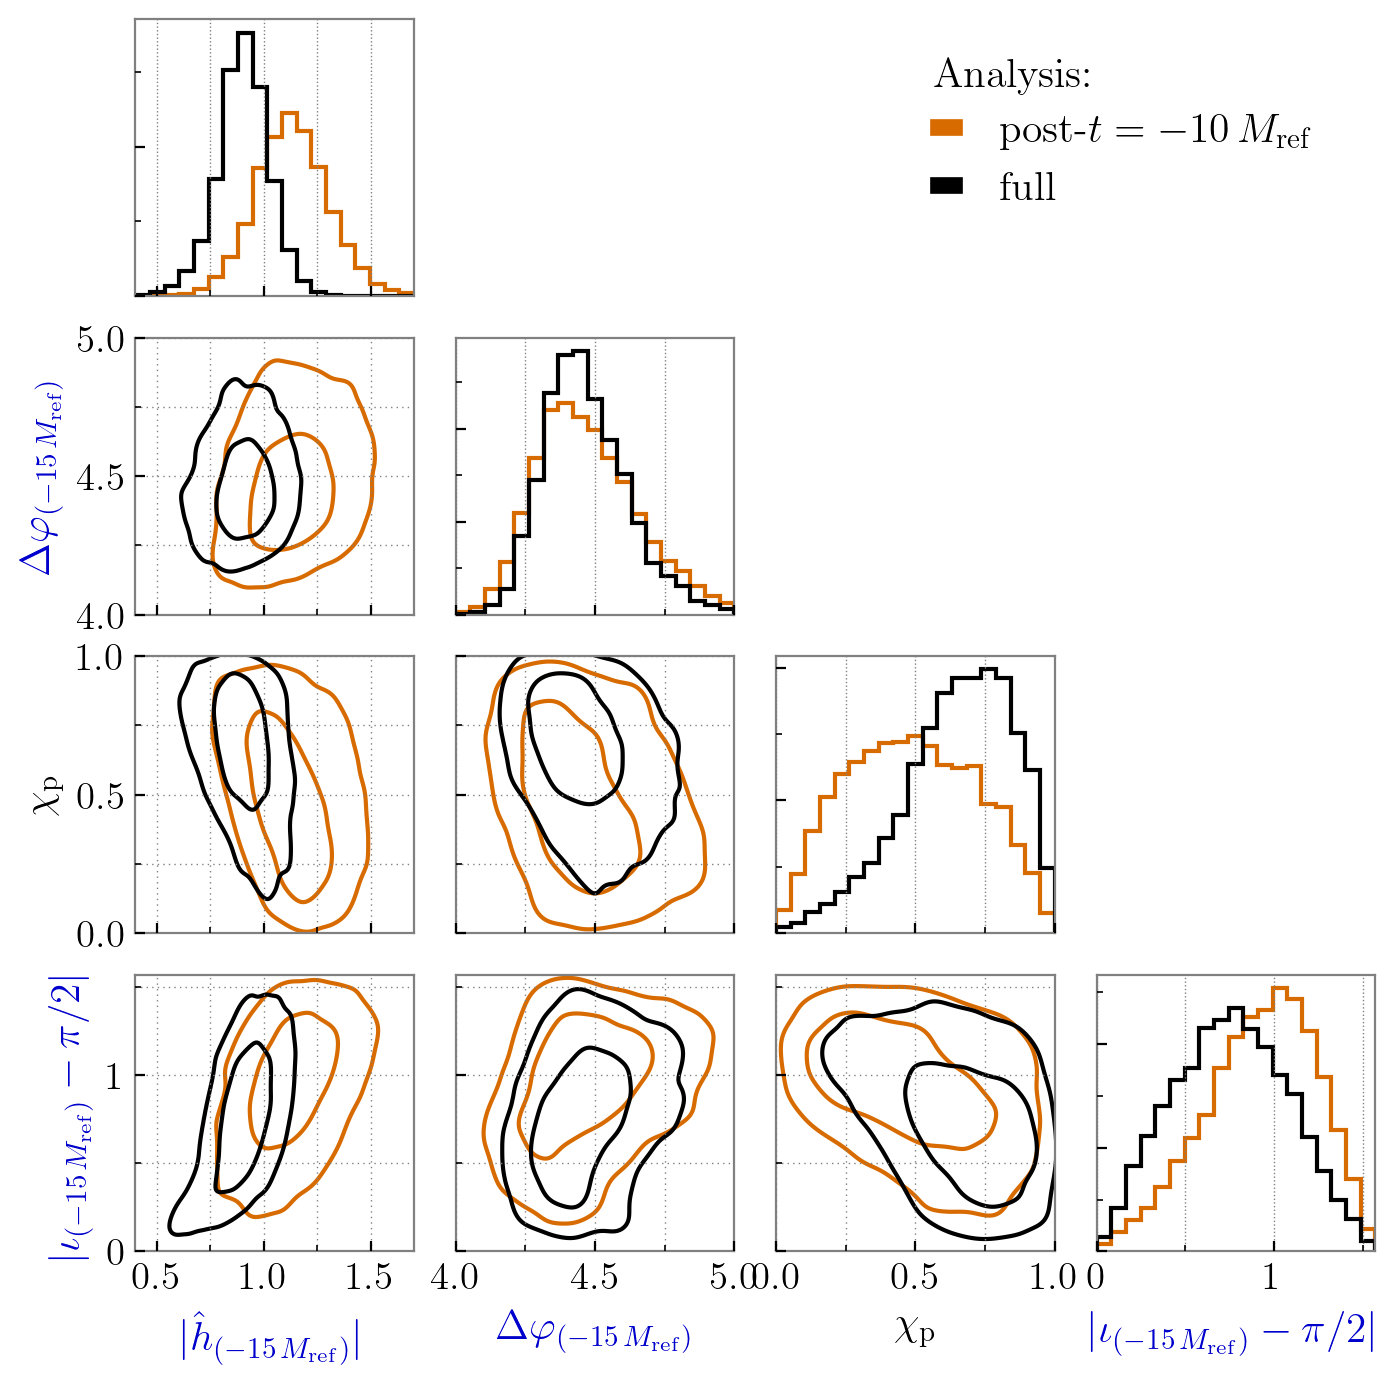

In [13]:
make_cornerPlot(
    ['h', 'phase', 'chip', 'iota'], 
    for_cp_dict,
    colors_dict, 
    bounds_dict, 
    labels_dict, 
    bins=20, 
    legend_handles=legend_handles, 
    legend_loc=(2.7, 0.8), 
    text_loc=(4.5, 2.8), 
    figsize=(8,8)
)